# Lab 05: Wine Quality

---
author: Alejandra Arias
date: October 11, 2024
embed-resources: true
---

## Introduction

## Methods

In [9]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor

### Data

In [3]:
# load data
wine_train = pd.read_csv(
    "https://cs307.org/lab-05/data/wine-train.csv",
)
wine_test = pd.read_csv(
    "https://cs307.org/lab-05/data/wine-test.csv",
)

In [3]:
wine_train 

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.6,0.23,0.64,12.9,0.033,54.0,170.0,0.99800,3.00,0.53,8.8,5,white
1,NaN,0.75,0.01,2.2,0.059,11.0,18.0,0.99242,3.39,0.40,NaN,6,red
2,7.4,0.67,0.12,1.6,0.186,5.0,21.0,0.99600,3.39,0.54,9.5,5,red
3,6.4,0.18,0.74,NaN,0.046,54.0,168.0,0.99780,3.58,0.68,10.1,5,white
4,6.7,0.35,0.32,9.0,0.032,29.0,113.0,0.99188,3.13,0.65,12.9,7,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4152,6.6,0.32,0.22,16.7,0.046,38.0,133.0,0.99790,3.22,0.67,10.4,6,white
4153,9.2,0.58,0.20,3.0,0.081,15.0,115.0,0.99800,3.23,0.59,9.5,5,red
4154,8.2,0.60,0.17,2.3,0.072,11.0,73.0,0.99630,3.20,0.45,9.3,5,red
4155,6.5,0.23,0.36,16.3,0.038,43.0,133.0,0.99924,3.26,0.41,8.8,5,white


In [6]:
# summary statistics
samples = X_train.shape[0]
features = X_train.shape[1] 
samples, features

(4157, 12)

In [7]:
# visualizations
wine_train.drop("color",axis=1).corr().iloc[11]

fixed acidity          -0.080703
volatile acidity       -0.267277
citric acid             0.091446
residual sugar         -0.040481
chlorides              -0.196897
free sulfur dioxide     0.056792
total sulfur dioxide   -0.037651
density                -0.306238
pH                      0.008376
sulphates               0.047955
alcohol                 0.444678
quality                 1.000000
Name: quality, dtype: float64

<Axes: xlabel='color'>

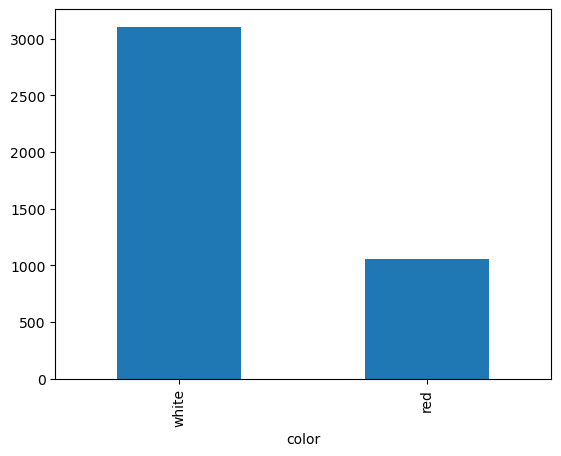

In [8]:
wine_train["color"].value_counts().plot(kind="bar")

### Models

In [4]:
# process data for ML
# create X and y for train
X_train = wine_train.drop("quality", axis=1)
y_train = wine_train["quality"]

# create X and y for test
X_test = wine_test.drop("quality", axis=1)
y_test = wine_test["quality"]


In [5]:
numeric_features = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "sulphates", "alcohol", "pH"]
categorical_features = ["color"]

In [12]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)


# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ]
)

# create pipeline, preprocess then classify
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("Regressor", KNeighborsRegressor()),
    ]
)

In [13]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'sulphates',
                                                   'alcohol', 'pH'])])),
                ('Regressor', KNeighborsRegressor())])

In [14]:
param_grid = {
    "Regressor": [HistGradientBoostingRegressor()],
    "Regressor__learning_rate": [0.1, 0.01, 0.001],
    "Regressor__max_iter": [1000],
    "Regressor__max_depth": [None, 3],
    "Regressor__l2_regularization": [0.1, 1.0],
}

In [15]:
# setup grid search with cross-validation
mod = GridSearchCV(pipeline, param_grid, cv=5, scoring="neg_mean_absolute_error")
mod.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['fixed '
                                                                          'acidity',
                                                                          'volatile '
                                                                          'acidity',
                                                                          'citric '
                                                                          'acid',
                                                                          'residual '
                                                                          'sugar',
                                                                          'chlorides',
                                                                          'free '
                                                                          'sulfur '
                                                                          'dioxide',
                                                                          'total '
                                                                          'sulfur '
                                                                          'dioxide',
                                                                          'density',
                                                                          'sulphates',
                                                                          'alcohol',
                                                                          'pH'])])),
                                       ('Regressor', KNeighborsRegressor())]),
             param_grid={'Regressor': [HistGradientBoostingRegressor()],
                         'Regressor__l2_regularization': [0.1, 1.0],
                         'Regressor__learning_rate': [0.1, 0.01, 0.001],
                         'Regressor__max_depth': [None, 3],
                         'Regressor__max_iter': [1000]},
             scoring='neg_mean_absolute_error')

In [16]:
print(f"Best parameters: {mod.best_params_}")
print(f"Best cross-validation accuracy: {mod.best_score_}")

Best parameters: {'Regressor': HistGradientBoostingRegressor(), 'Regressor__l2_regularization': 0.1, 'Regressor__learning_rate': 0.1, 'Regressor__max_depth': None, 'Regressor__max_iter': 1000}
Best cross-validation accuracy: -0.47993167280292814


In [17]:
y_pred = mod.predict(X_test)
mae = np.mean(np.abs(y_test - y_pred))
mae

0.46958893446413014

In [18]:
from joblib import dump
dump(mod, "wine-quality.joblib", compress=True)

['wine-quality.joblib']

## Results

In [ ]:
# report model metrics

## Discussion

### Conclusion